<a href="https://colab.research.google.com/github/jiananwu72/Defect-Detection/blob/main/AtomAIDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source
!pip install -q pyNSID sidpy SciFiReaders wget
!pip install numpy==1.26.4

  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-3cv9_973
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-3cv9_973
  Resolved https://github.com/pycroscopy/atomai to commit 8db3e944cd9ece68c33c8e3fcca3ef3ce9a111ea
  Preparing metadata (setup.py) ... done


In [2]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


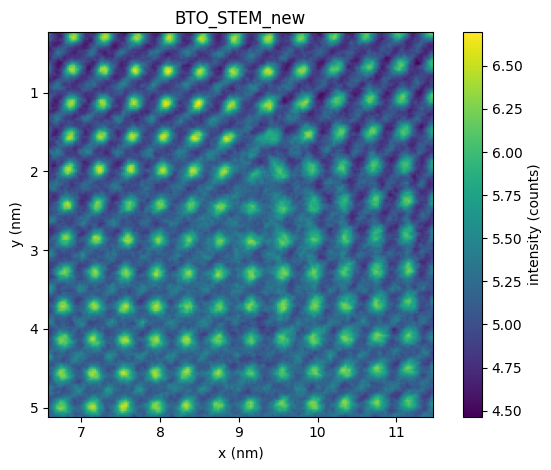

In [3]:
import wget
import SciFiReaders as sr
wget.download(url='https://zenodo.org/record/8190744/files/bto_atomic.dm3?download=1',
              out = 'bto_atomic.dm3')

dm3_file = r'bto_atomic.dm3'
dm3_reader = sr.DM3Reader(dm3_file)
dataset = dm3_reader.read()["Channel_000"]
dataset.title = 'BTO_STEM'
dataset._axes[0].quantity = 'x'
dataset._axes[1].quantity = 'y'
# dataset = dataset[700:900,150:350]

dataset = dataset[270:470,10:210]
dataset.plot();

In [4]:
expdata = np.array(dataset)

In [5]:
download_link1 = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
download_link2 = 'https://drive.google.com/uc?id=18JK9GcMPMWHmHtwArujVQRLr6N4VIM_j'
!gdown -q $download_link1 -O 'training_data.npy'
!gdown -q $download_link2 -O 'validation_data.npy'

# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('training_data.npy')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']
# Load validation data (data from different experiment)
# expdata = np.load("validation_data.npy")

In [6]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(1656, 1, 256, 256) (1656, 256, 256)
(414, 1, 256, 256) (414, 256, 256)


##Training Data

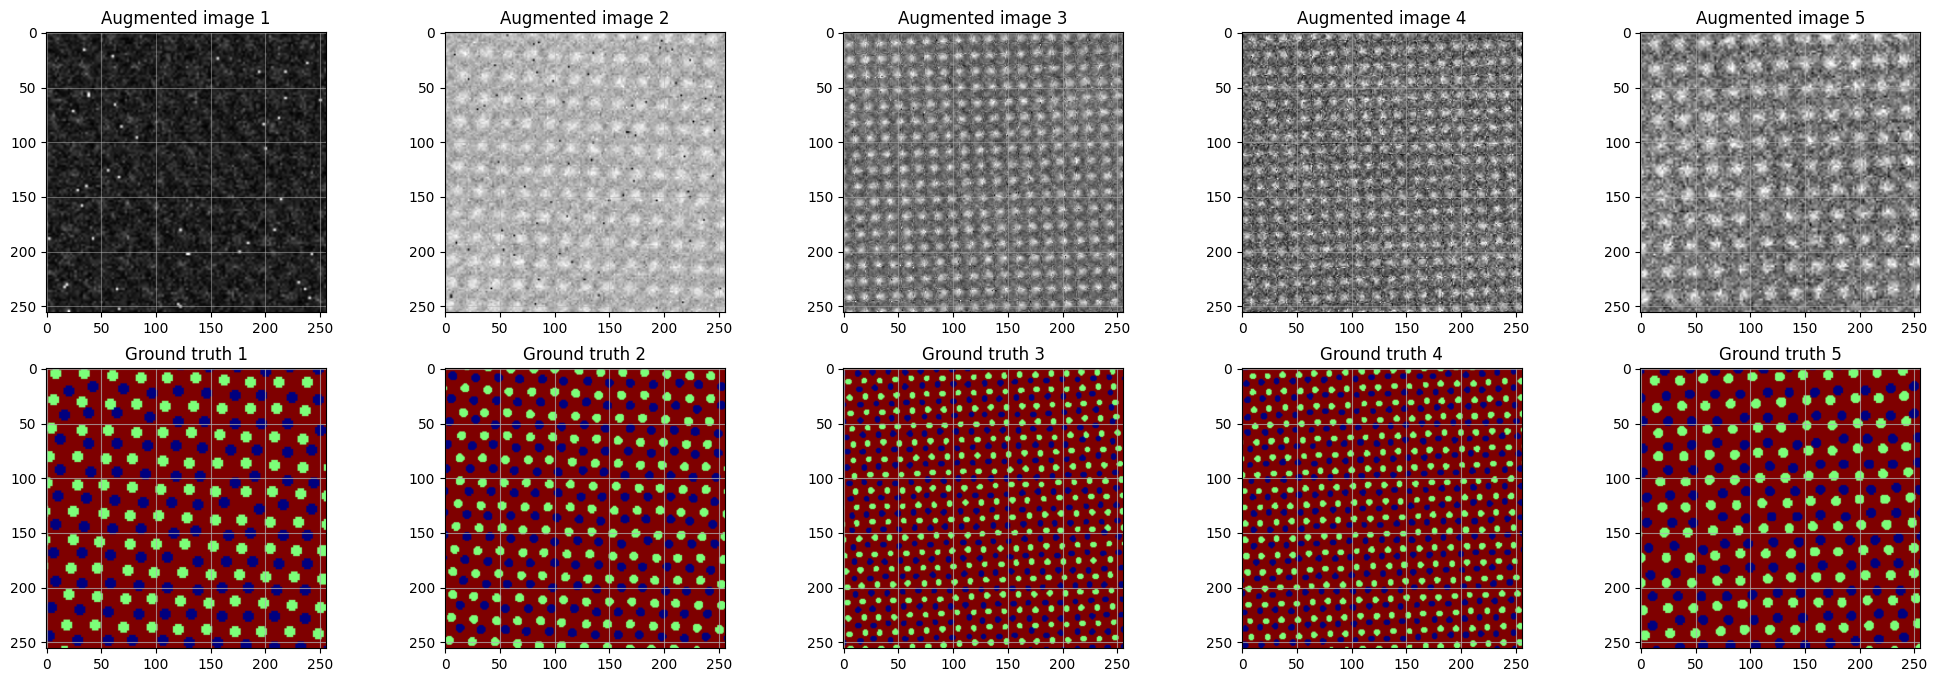

In [7]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

In [8]:
model = aoi.models.Segmentor(nb_classes=3)

In [9]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Epoch 1/300 ... Training loss: 1.2846 ... Test loss: 1.2103 ... Train Accuracy: 0.0901 ... Test Accuracy: 0.0405 ... GPU memory usage: 6172/15360
Epoch 100/300 ... Training loss: 0.4585 ... Test loss: 0.4083 ... Train Accuracy: 0.6645 ... Test Accuracy: 0.6632 ... GPU memory usage: 7038/15360
Epoch 200/300 ... Training loss: 0.2734 ... Test loss: 0.2467 ... Train Accuracy: 0.7223 ... Test Accuracy: 0.7414 ... GPU memory usage: 7038/15360
Epoch 300/300 ... Training loss: 0.236 ... Test loss: 0.2222 ... Train Accuracy: 0.7352 ... Test Accuracy: 0.7431 ... GPU memory usage: 7038/15360
Model (final state) evaluation loss: 0.2364
Model (final state) accuracy: 0.7234
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.231
Model (final state) accuracy: 0.7297
Plotting training history


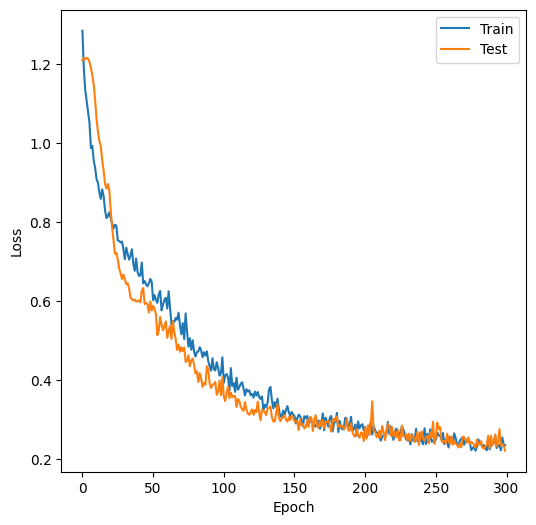

In [10]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True # training parameters
)

In [11]:
nn_output, coordinates = model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.0221 seconds


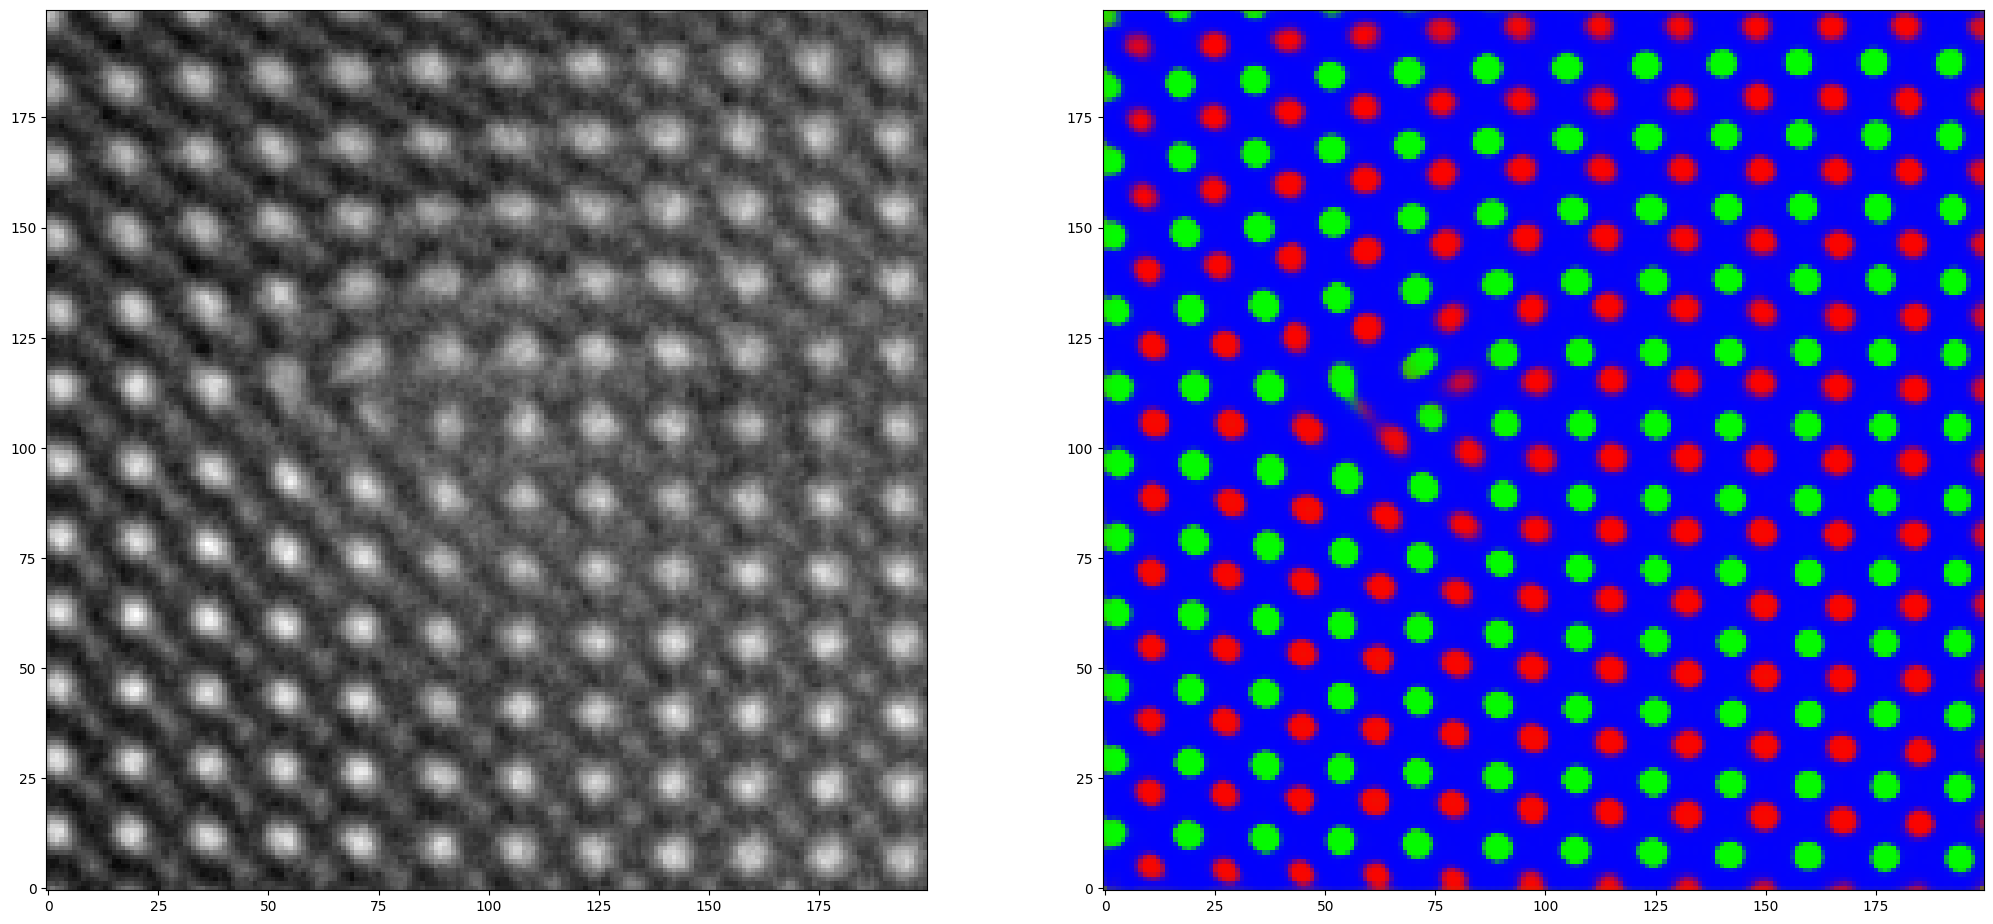

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

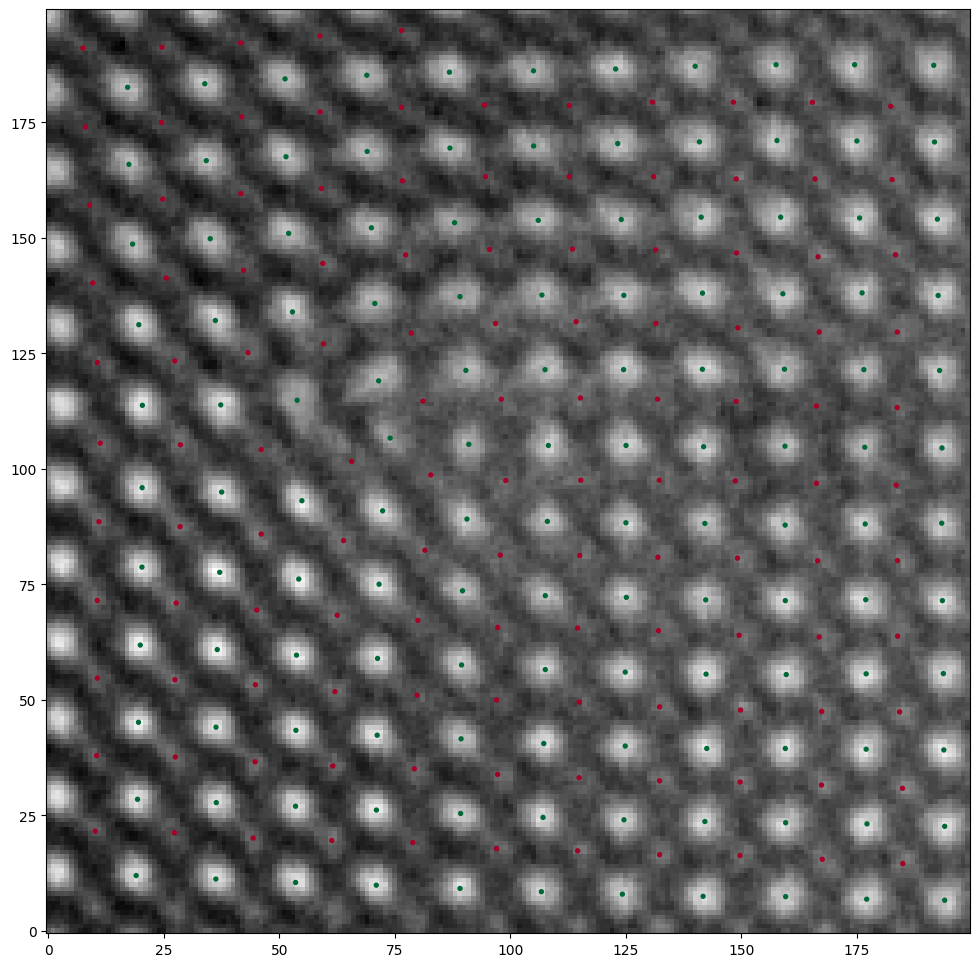

In [14]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

##PCA

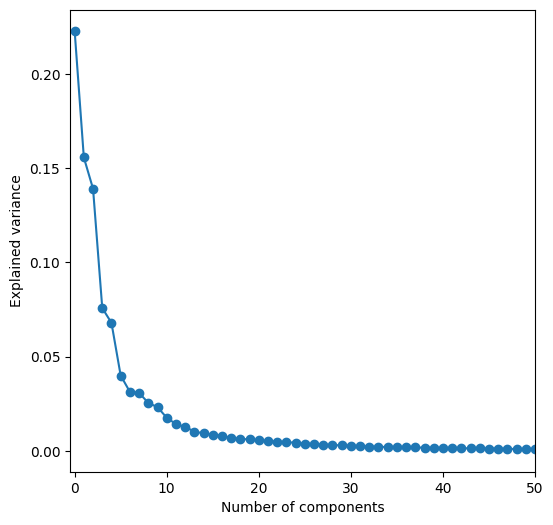

In [15]:
imstack = aoi.stat.imlocal(nn_output, coordinates, window_size=32, coord_class=1)
imstack.pca_scree_plot(plot_results=True);

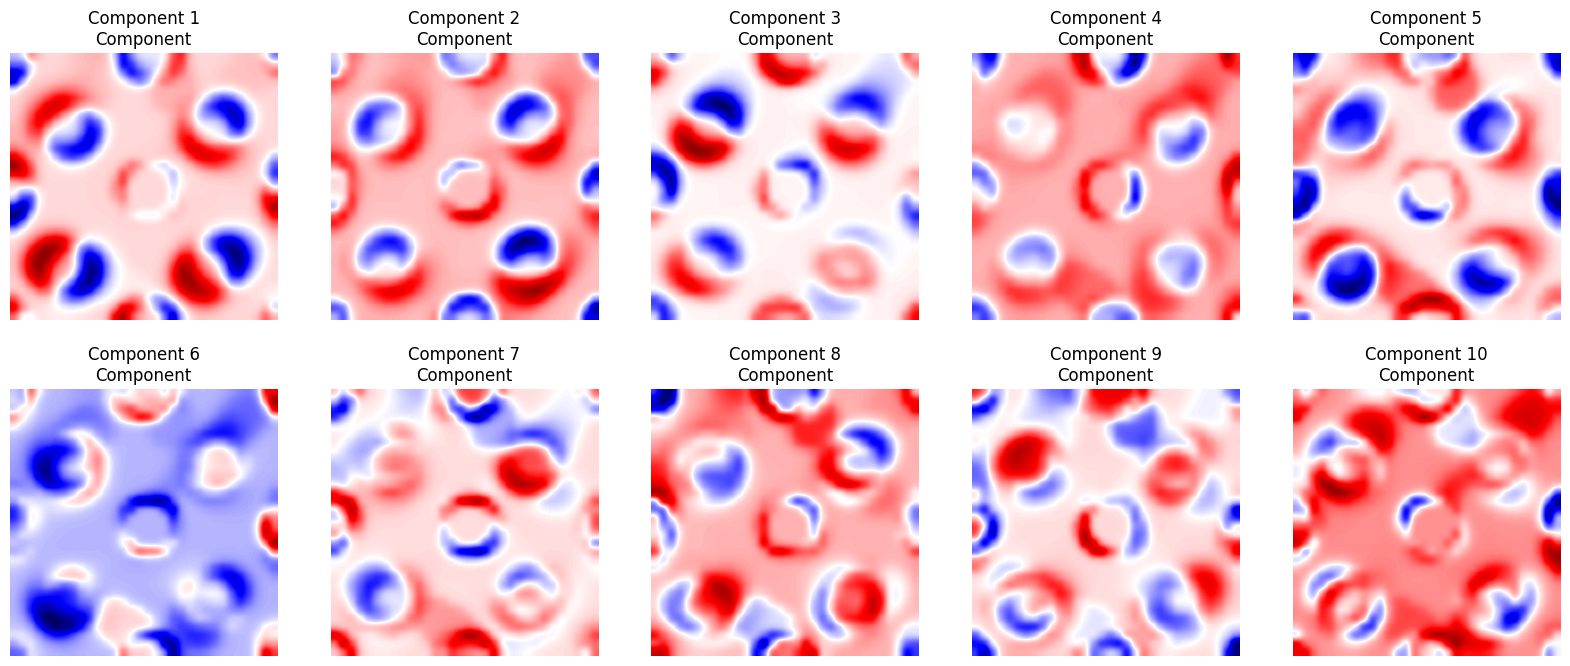

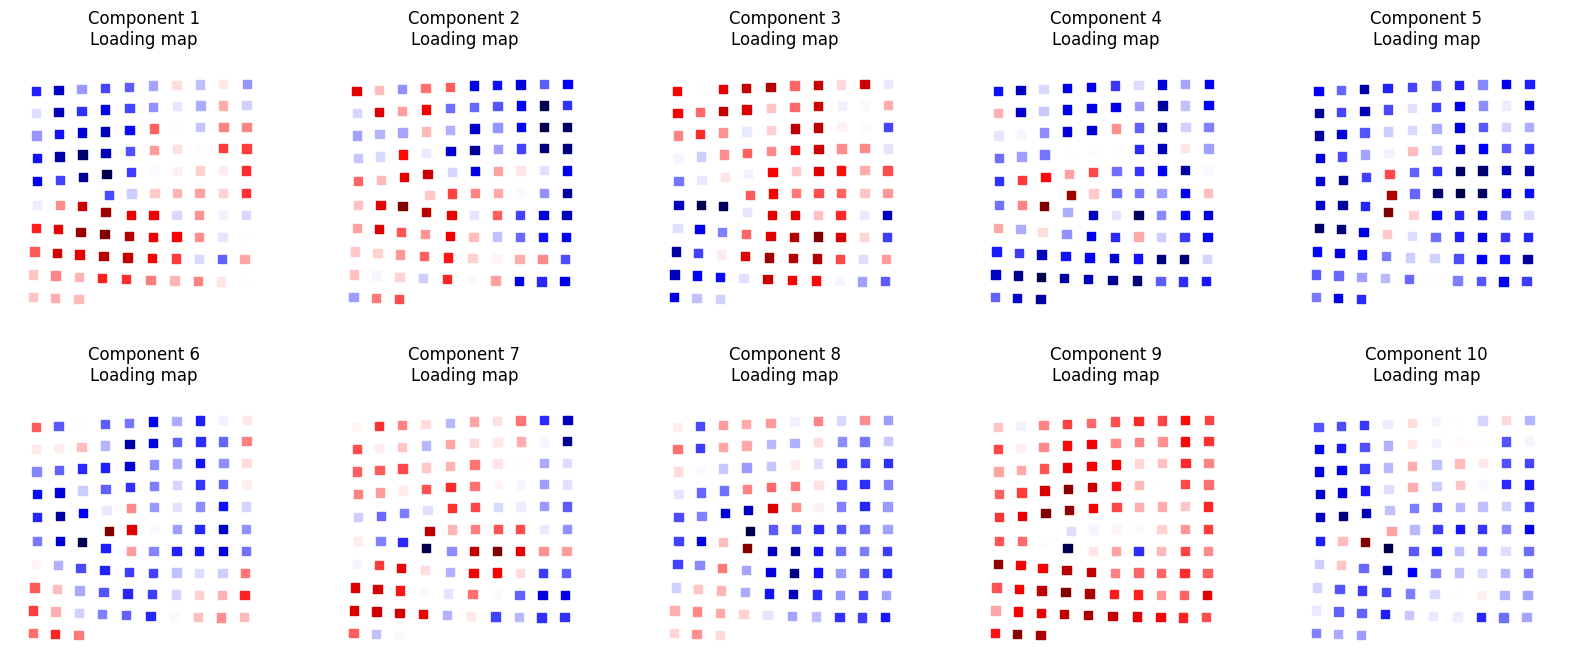

In [20]:
pca_results = imstack.imblock_pca(10, plot_results=True)

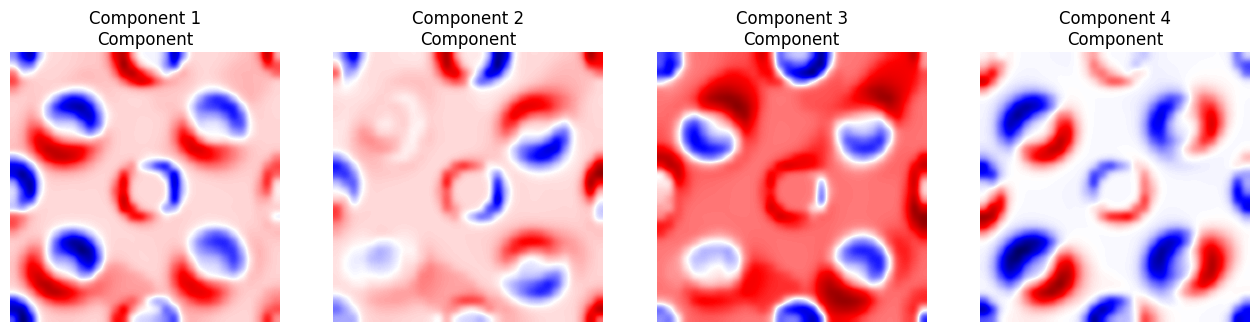

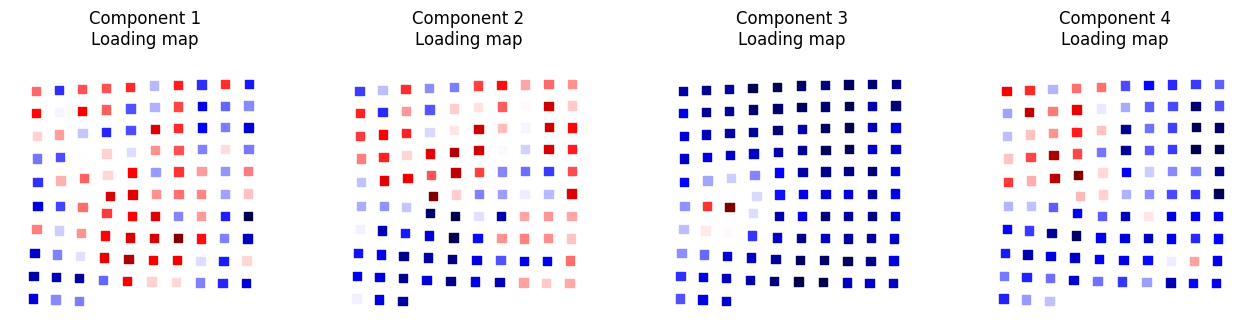

In [17]:
ica_results = imstack.imblock_ica(4, plot_results=True)

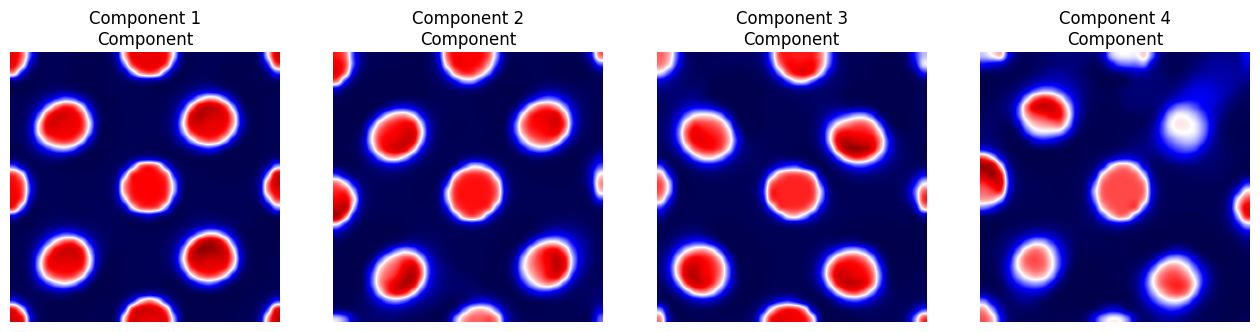

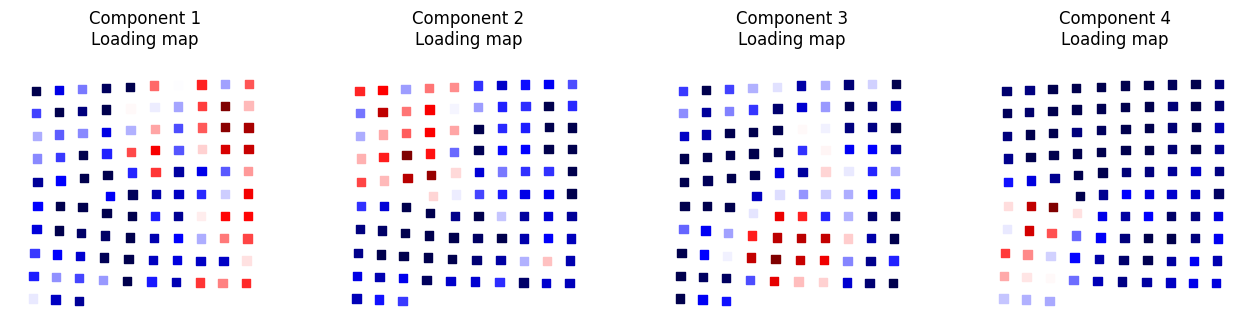

In [18]:
nmf_results = imstack.imblock_nmf(4, plot_results=True)